# Quantum Variational Circuit
In this notebook we will implement a quantum variational circuit (QVC), we use it as a binary classificator for detecting entanglement in a quantum state.

In [2]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import IQPEmbedding, StronglyEntanglingLayers

import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

from tqdm.auto import trange

## Dataset

The dataset contains 10,000 examples consisting of 10 features and a binary label: _sep_. The feature are rappresente as observable generated from a determined quantum state.
The dataset is ```ds_mixed_obs```.


In [3]:
# Number of total exemples 
n_exemples = 1500

# Loading dataset with pandas
dataset = pd.read_csv('../datasets/ds_mixed_obs.csv')
dataset = dataset[:n_exemples]
dataset

,OBS_0,OBS_1,OBS_2,OBS_3,OBS_4,OBS_5,OBS_6,OBS_7,OBS_8,OBS_9,separable
0,0.268372,0.246112,0.320277,0.157779,0.255752,0.174061,0.301679,0.233190,0.208881,0.241814,False
1,0.241903,0.239770,0.258264,0.253273,0.243815,0.277775,0.223547,0.237721,0.237809,0.241504,False
2,0.185326,0.223879,0.240827,0.249868,0.232626,0.242109,0.246553,0.233927,0.234095,0.246902,True
3,0.233334,0.252164,0.278026,0.249751,0.236253,0.240901,0.245941,0.248044,0.280448,0.269990,False
4,0.234331,0.234900,0.250295,0.248989,0.247575,0.252747,0.250756,0.240557,0.257094,0.250061,True
...,...,...,...,...,...,...,...,...,...,...,...
1495,0.213068,0.241627,0.164797,0.233035,0.304116,0.251319,0.261124,0.249533,0.244896,0.281999,False
1496,0.295431,0.183081,0.222160,0.320608,0.261499,0.309888,0.290684,0.258127,0.152506,0.274895,False
1497,0.251769,0.235655,0.240658,0.210569,0.250817,0.245811,0.241521,0.240948,0.239477,0.245323,True
1498,0.256584,0.252778,0.257748,0.267818,0.280131,0.265739,0.246184,0.249315,0.257751,0.245983,True


In [13]:
# Number of features
n_features = 8

# Dividing dataset in features and label
X = dataset.to_numpy()[:,0:n_features]
y = dataset.to_numpy()[:,-1]

# Scaling the inputs 
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Redifining labels on -1,1
y_scaled = np.array(2 * (y - 0.5),dtype=int)

In [14]:
# Spliting dataset in training and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,train_size=0.8)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 1200
Test size: 300


In [15]:
# Setting the number of qbits the same as the number of features
n_qubits = len(X_train[0])
print("Number of Qbits: ",n_qubits)

Number of Qbits:  8


## Quantum Circuit

In [16]:
dev_var = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_var, diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    #IQPEmbedding(x, wires=range(n_qubits),n_repeats=2)
    qml.AngleEmbedding(x, wires=range(n_qubits))


    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

/Users/paolodarold/opt/anaconda3/envs/QML/lib/python3.9/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:901: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


## Functions

In [17]:
def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.01)

    loss_history = []
    train_acc_history = []

    for i in trange(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)

            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history

def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""
    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

def quantum_model_predict_prob(X_pred, trained_params, trained_bias):
    """Predict the probability using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        p.append(pred)
    return p



## Training and test

In [18]:
n_layers = 4
batch_size = 24
steps = 50
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 , loss 1.0118828567842224
step 10 , loss 0.9181715650213462
step 20 , loss 0.9819161679378823
step 30 , loss 0.9346458475922156
step 40 , loss 0.8069935305766731


In [26]:
pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))
pred_test_prob = quantum_model_predict_prob(X_test, trained_params, trained_bias)


accuracy on test set: 0.6466666666666666


## The plot

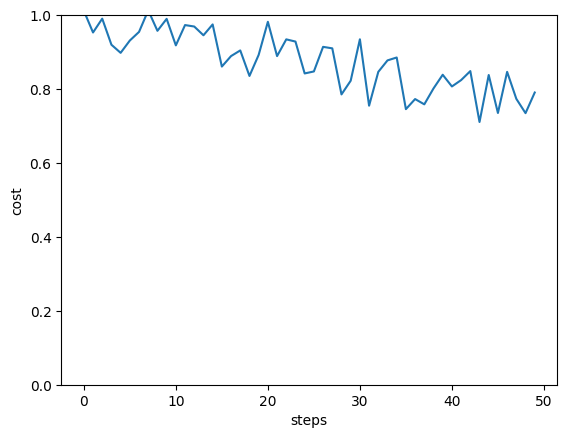

In [27]:
plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

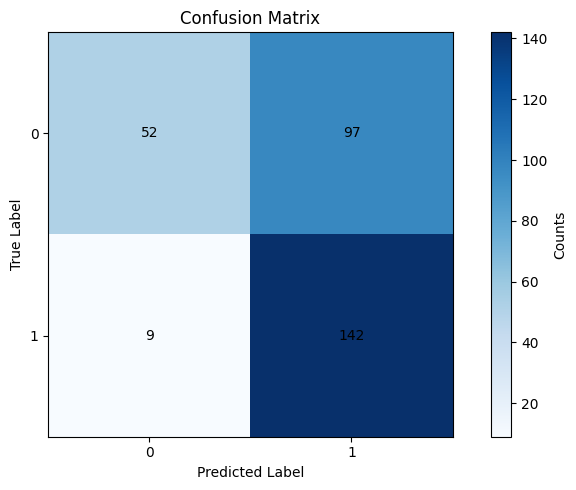

In [28]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# Add labels
plt.title('Confusion Matrix')
plt.xticks(np.arange(2), ['0', '1']) # Set x-axis ticks
plt.yticks(np.arange(2), ['0', '1']) # Set y-axis ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar(label='Counts')


# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')


plt.tight_layout()
plt.show()


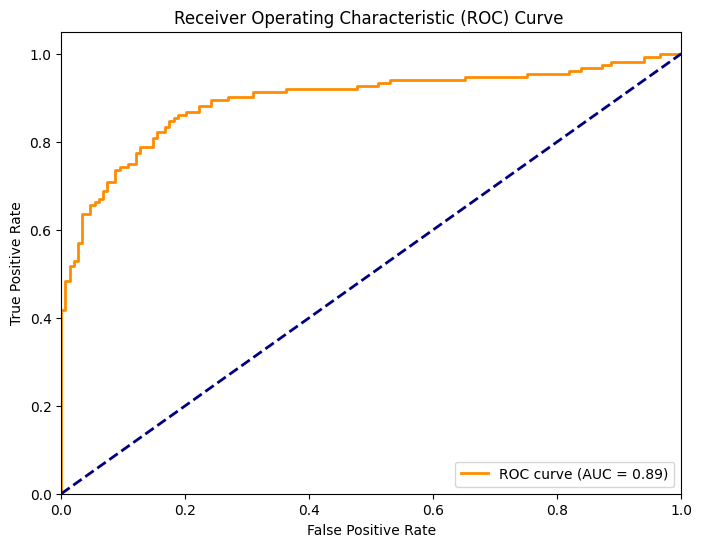

In [29]:
from sklearn.metrics import roc_curve, auc

    

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_test_prob)

# Calculate Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve ')
plt.legend(loc='lower right')
plt.show()